# Housing Price Prediction Baselines

This notebook implements baseline models for housing price prediction to compare with the main GCN-LSTM model.
The baselines included are:
1. **ARIMA**: AutoRegressive Integrated Moving Average (Statistical baseline)
2. **XGBoost**: Extreme Gradient Boosting (Tree-based baseline)
3. **TFT**: Temporal Fusion Transformer (Transformer-based baseline)
4. **TabNet**: Attentive Interpretable Tabular Learning (Deep Learning baseline)

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import requests
import zipfile
import io
import os

warnings.filterwarnings('ignore')

# Modeling libraries
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import xgboost as xgb
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

# Deep Learning
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# Check for specialized libraries
try:
    import pytorch_lightning as pl
    from pytorch_forecasting import TemporalFusionTransformer, TimeSeriesDataSet
    from pytorch_forecasting.data import GroupNormalizer
    from pytorch_forecasting.metrics import QuantileLoss, RMSE, MAE
    HAS_TFT = True
    print("pytorch_forecasting is available.")
except ImportError:
    HAS_TFT = False
    print("pytorch_forecasting not found. TFT section will be skipped or require installation.")

try:
    from pytorch_tabnet.tab_model import TabNetRegressor
    HAS_TABNET = True
    print("pytorch_tabnet is available.")
except ImportError:
    HAS_TABNET = False
    print("pytorch_tabnet not found. TabNet section will be skipped or require installation.")

# Setup
plt.style.use('seaborn-v0_8')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# --- Configuration & Data Loading (Adapted from housing_final.ipynb) ---

class Config:
    # Direct raw URL to the correct path
    HOUSING_DATA_URL = "https://raw.githubusercontent.com/IflyNY2PR/CASA0004/9fa65c8ebe6cb3156cf9c1dac130b98264dcc15a/data%26preprocessing/economic/housing-value.csv"
    
    # Local data directory
    DATA_DIR = Path('./housing_data')
    
    # Model parameters
    SEQUENCE_LENGTH = 12
    PREDICTION_HORIZON = 4
    SEED = 42

config = Config()
config.DATA_DIR.mkdir(parents=True, exist_ok=True)

def download_housing_data():
    housing_file = config.DATA_DIR / 'housing-value.csv'
    if not housing_file.exists():
        print("Downloading housing value data...")
        try:
            response = requests.get(config.HOUSING_DATA_URL)
            response.raise_for_status()
            with open(housing_file, 'wb') as f:
                f.write(response.content)
            print(f"Downloaded to {housing_file}")
        except Exception as e:
            print(f"Error: {e}")
            return None
    return housing_file

# Load Data
housing_file_path = download_housing_data()
if housing_file_path:
    df_raw = pd.read_csv(housing_file_path, encoding='utf-8-sig')
    print(f"Data loaded. Shape: {df_raw.shape}")
else:
    raise FileNotFoundError("Could not load data.")


pytorch_forecasting is available.
pytorch_tabnet is available.
Using device: cpu
Data loaded. Shape: (34753, 112)


In [2]:
# --- Data Preprocessing ---

def preprocess_data(df):
    """
    Melts the wide dataframe into a long format suitable for time series modeling.
    Optimized for speed and handles string formatting in prices.
    """
    print("Identifying columns...")
    # Better heuristic: Try to parse columns as dates.
    date_cols = []
    metadata_cols = []
    
    for col in df.columns:
        try:
            # Try parsing typical formats
            pd.to_datetime(col, errors='raise')
            date_cols.append(col)
        except:
            # If simple parsing fails, check for specific formats like "Year ending Dec 1995"
            if 'Year' in col or 'Quarter' in col or '-' in col:
                 date_cols.append(col)
            else:
                metadata_cols.append(col)
                
    print(f"Identified {len(metadata_cols)} metadata columns and {len(date_cols)} time columns.")
    
    # Melt
    print("Melting dataframe (this may take a moment)...")
    df_long = df.melt(id_vars=metadata_cols, var_name='date_str', value_name='price')
    
    # Optimize date parsing: Parse unique values only
    print("Parsing dates...")
    unique_date_strs = df_long['date_str'].unique()
    date_map = {}
    
    def parse_date_single(d_str):
        try:
            return pd.to_datetime(d_str)
        except:
            # Handle "Year ending Dec 1995" -> "1995-12-31"
            if 'Year ending' in str(d_str):
                parts = str(d_str).split()
                year = parts[-1]
                month = parts[-2] # Dec
                return pd.to_datetime(f"{year}-{month}-01") + pd.offsets.MonthEnd(0)
            return pd.NaT

    for d_str in unique_date_strs:
        date_map[d_str] = parse_date_single(d_str)

    df_long['date'] = df_long['date_str'].map(date_map)
    
    # Drop invalid dates
    df_long = df_long.dropna(subset=['date'])
    
    print("Cleaning price data...")
    # Handle string formatting in price (e.g., "34,750" or ":")
    if df_long['price'].dtype == 'object':
        # Remove commas and handle colons
        df_long['price'] = df_long['price'].astype(str).str.replace(',', '', regex=False)
        # Replace ':' with NaN (or let to_numeric handle it if it's just non-numeric)
    
    df_long['price'] = pd.to_numeric(df_long['price'], errors='coerce')
    df_long = df_long.dropna(subset=['price'])
    
    print("Sorting data...")
    df_long = df_long.sort_values(['date'])
    
    # Create a time index (integer) for some models
    dates = sorted(df_long['date'].unique())
    date_map_idx = {d: i for i, d in enumerate(dates)}
    df_long['time_idx'] = df_long['date'].map(date_map_idx)
    
    return df_long, metadata_cols

print("Starting preprocessing...")
df_long, id_cols = preprocess_data(df_raw)
print("Data melted and processed.")
print(df_long.head())

# Select a subset for faster demonstration if needed, or use full dataset
# For baselines, we might want to aggregate to Borough level to save time/compute
# or pick a specific LSOA.
# Let's aggregate to Borough level for the baselines to make it runnable in reasonable time.
borough_col = [c for c in id_cols if 'borough' in c.lower() or 'name' in c.lower()]
if borough_col:
    group_col = borough_col[0] # Use the first one found
    print(f"Aggregating by {group_col} for baseline models...")
    df_agg = df_long.groupby([group_col, 'date', 'time_idx'])['price'].mean().reset_index()
    df_agg.rename(columns={group_col: 'series_id'}, inplace=True)
else:
    # Fallback: use LSOA code
    print("Aggregating by LSOA code...")
    df_agg = df_long.copy()
    df_agg.rename(columns={id_cols[0]: 'series_id'}, inplace=True)

print(f"Aggregated data shape: {df_agg.shape}")
print(f"Number of series: {df_agg['series_id'].nunique()}")

# Train/Test Split
train_cutoff = df_agg['time_idx'].max() - config.PREDICTION_HORIZON
train_df = df_agg[df_agg['time_idx'] <= train_cutoff]
test_df = df_agg[df_agg['time_idx'] > train_cutoff]

print(f"Train samples: {len(train_df)}, Test samples: {len(test_df)}")

Starting preprocessing...
Identifying columns...
Identified 2 metadata columns and 110 time columns.
Melting dataframe (this may take a moment)...
Parsing dates...
Cleaning price data...
Sorting data...
Data melted and processed.
       LSOA code        LSOA name              date_str    price       date  \
0      E01011949  Hartlepool 009A  Year ending Dec 1995  34750.0 1995-12-31   
22888  E01006835  St. Helens 016C  Year ending Dec 1995  50475.0 1995-12-31   
22887  E01006834  St. Helens 012B  Year ending Dec 1995  29750.0 1995-12-31   
22886  E01006833  St. Helens 016B  Year ending Dec 1995  30475.0 1995-12-31   
22885  E01006832  St. Helens 012A  Year ending Dec 1995  49950.0 1995-12-31   

       time_idx  
0             0  
22888         0  
22887         0  
22886         0  
22885         0  
Aggregating by LSOA name for baseline models...
Aggregated data shape: (3741179, 4)
Number of series: 34743
Train samples: 3605338, Test samples: 135841


In [3]:
# --- UNIFIED DATA PREPARATION (Matching housing_final.ipynb) ---
print("\n" + "="*60)
print("PREPARING UNIFIED DATA FOR BASELINE MODELS")
print("="*60)

# Convert to LSOA-level data (NOT aggregated to Borough)
print("Converting to LSOA-level data (no aggregation)...")

# Identify LSOA columns
lsoa_cols = [c for c in df_long.columns if 'LSOA' in c]
if len(lsoa_cols) >= 2:
    lsoa_code_col = [c for c in lsoa_cols if 'code' in c.lower()][0]
    lsoa_name_col = [c for c in lsoa_cols if 'name' in c.lower()][0]
elif len(lsoa_cols) == 1:
    lsoa_code_col = lsoa_cols[0]
    lsoa_name_col = lsoa_cols[0]
else:
    lsoa_code_col = id_cols[0]
    lsoa_name_col = id_cols[1] if len(id_cols) > 1 else id_cols[0]

# Create LSOA-level dataset
df_unified = df_long.copy()
df_unified = df_unified.rename(columns={
    lsoa_code_col: 'LSOA code',
    lsoa_name_col: 'LSOA name' if lsoa_name_col != lsoa_code_col else 'LSOA name'
} if lsoa_name_col != lsoa_code_col else {lsoa_code_col: 'LSOA code'})

# Pivot to wide format for standardization
pivot_cols = [c for c in df_unified.columns if c not in ['date', 'date_str', 'time_idx']]
date_sorted = sorted(df_unified['date_str'].unique())

housing_unified = df_unified.pivot_table(
    index=[c for c in pivot_cols if c not in df_unified['date_str'].unique()],
    columns='date_str',
    values='price',
    aggfunc='mean'
).reset_index()

print(f"✅ Unified data shape: {housing_unified.shape}")
print(f"   Time periods: {len(date_sorted)}")
print(f"   LSOAs: {len(housing_unified)}")

# Extract price matrix
price_matrix = housing_unified[date_sorted].values

# Standardize using StandardScaler (matching housing_final.ipynb)
print("Standardizing prices using StandardScaler...")
scaler_unified = StandardScaler()
price_matrix_flat = price_matrix.reshape(-1)
price_matrix_reshaped = price_matrix.T  # Time x LSOAs
price_normalized = scaler_unified.fit_transform(price_matrix_reshaped)
price_normalized = price_normalized.T  # Back to LSOAs x Time

print(f"✅ Standardization complete")
print(f"   Scaler mean (avg price): £{scaler_unified.mean_[0]:,.0f}")
print(f"   Scaler std (price volatility): £{scaler_unified.scale_[0]:,.0f}")

# Create sequences (matching housing_final.ipynb)
print(f"\nCreating time series sequences...")
print(f"  Sequence length: {config.SEQUENCE_LENGTH}")
print(f"  Prediction horizon: {config.PREDICTION_HORIZON}")

sequences_unified = []
targets_unified = []

n_lsoas, n_periods = price_normalized.shape

for t in range(config.SEQUENCE_LENGTH, n_periods - config.PREDICTION_HORIZON + 1):
    seq = price_normalized[:, t-config.SEQUENCE_LENGTH:t]
    target = price_normalized[:, t:t+config.PREDICTION_HORIZON]
    sequences_unified.append(seq)
    targets_unified.append(target)

sequences_unified = np.array(sequences_unified)
targets_unified = np.array(targets_unified)

print(f"✅ Generated {len(sequences_unified)} sequences")
print(f"   Sequence shape: {sequences_unified.shape}")
print(f"   Target shape: {targets_unified.shape}")

# Split data (70% train, 15% val, 15% test - matching housing_final.ipynb)
print(f"\nSplitting data into train/val/test...")
n_sequences = len(sequences_unified)
train_end = int(n_sequences * 0.70)
val_end = int(n_sequences * 0.85)

train_seq = sequences_unified[:train_end]
train_tgt = targets_unified[:train_end]

val_seq = sequences_unified[train_end:val_end]
val_tgt = targets_unified[train_end:val_end]

test_seq = sequences_unified[val_end:]
test_tgt = targets_unified[val_end:]

print(f"✅ Data split complete")
print(f"   Train: {len(train_seq)} sequences")
print(f"   Val:   {len(val_seq)} sequences")
print(f"   Test:  {len(test_seq)} sequences")



PREPARING UNIFIED DATA FOR BASELINE MODELS
Converting to LSOA-level data (no aggregation)...
✅ Unified data shape: (34743, 112)
   Time periods: 110
   LSOAs: 34743
Standardizing prices using StandardScaler...
✅ Standardization complete
   Scaler mean (avg price): £60,080
   Scaler std (price volatility): £31,868

Creating time series sequences...
  Sequence length: 12
  Prediction horizon: 4
✅ Generated 95 sequences
   Sequence shape: (95, 34743, 12)
   Target shape: (95, 34743, 4)

Splitting data into train/val/test...
✅ Data split complete
   Train: 66 sequences
   Val:   14 sequences
   Test:  15 sequences


Running ARIMA baseline...
Running on first 20 series out of 34743 for demonstration...


/Users/goffy/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Users/goffy/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Users/goffy/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Users/goffy/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported

ARIMA RMSE: 54248.6501


/Users/goffy/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Users/goffy/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Users/goffy/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Users/goffy/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported

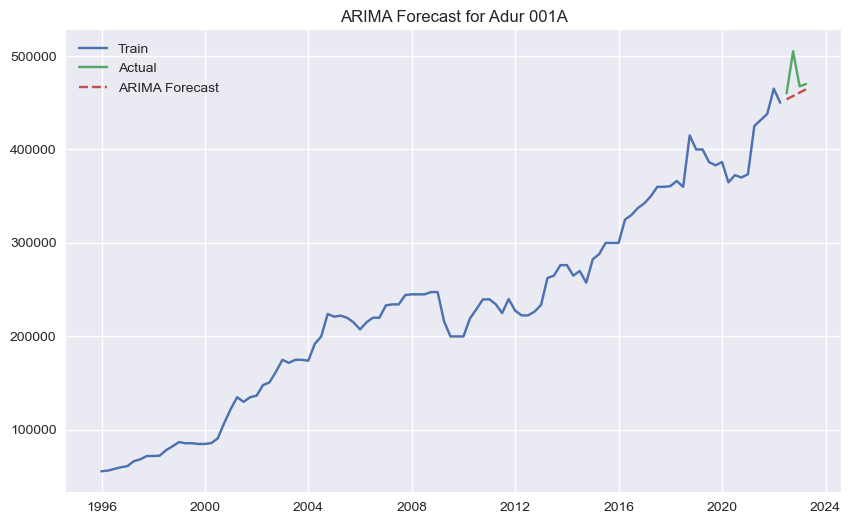

In [4]:
# --- Baseline 1: ARIMA ---

def fit_predict_arima(series, horizon):
    """
    Fits an ARIMA model and predicts the next 'horizon' steps.
    Uses a simple (1,1,1) order for speed, or auto_arima if available (but slow).
    """
    # Simple order (p,d,q)
    order = (1, 1, 1)
    
    try:
        model = ARIMA(series, order=order)
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=horizon)
        return forecast
    except:
        return np.zeros(horizon)

print("Running ARIMA baseline...")
arima_preds = []
arima_actuals = []

# Guard against missing/empty data
if df_agg.empty or np.isnan(train_cutoff) or df_agg['series_id'].nunique() == 0:
    print("⚠️ No data available to run ARIMA baseline. Skipping.")
    arima_rmse = np.nan
else:
    # Iterate over each series
    unique_series = df_agg['series_id'].unique()
    # Limit for demonstration if too many
    if len(unique_series) > 20:
        print(f"Running on first 20 series out of {len(unique_series)} for demonstration...")
        eval_series = unique_series[:20]
    else:
        eval_series = unique_series

    if len(eval_series) == 0:
        print("⚠️ No series found to evaluate. Skipping ARIMA.")
        arima_rmse = np.nan
    else:
        for sid in eval_series:
            series_data = df_agg[df_agg['series_id'] == sid].sort_values('time_idx')
            train_series = series_data[series_data['time_idx'] <= train_cutoff]['price']
            test_series = series_data[series_data['time_idx'] > train_cutoff]['price']
            
            if len(test_series) == config.PREDICTION_HORIZON and len(train_series) > 0:
                preds = fit_predict_arima(train_series, config.PREDICTION_HORIZON)
                arima_preds.extend(preds)
                arima_actuals.extend(test_series)

        if len(arima_actuals) == 0 or len(arima_preds) == 0:
            print("⚠️ No predictions were generated for ARIMA. RMSE set to NaN.")
            arima_rmse = np.nan
        else:
            arima_rmse = np.sqrt(mean_squared_error(arima_actuals, arima_preds))
            print(f"ARIMA RMSE: {arima_rmse:.4f}")

# Plot one example (only if results exist)
if len(arima_preds) > 0 and len(arima_actuals) > 0:
    plt.figure(figsize=(10, 6))
    example_sid = eval_series[0]
    series_data = df_agg[df_agg['series_id'] == example_sid].sort_values('time_idx')
    train_series = series_data[series_data['time_idx'] <= train_cutoff]
    test_series = series_data[series_data['time_idx'] > train_cutoff]

    model = ARIMA(train_series['price'], order=(1,1,1))
    fit = model.fit()
    fc = fit.forecast(steps=config.PREDICTION_HORIZON)

    plt.plot(train_series['date'], train_series['price'], label='Train')
    plt.plot(test_series['date'], test_series['price'], label='Actual')
    plt.plot(test_series['date'], fc, label='ARIMA Forecast', linestyle='--')
    plt.title(f"ARIMA Forecast for {example_sid}")
    plt.legend()
    plt.show()

Preparing features for XGBoost...
Training XGBoost...
XGBoost RMSE: 88132.8231


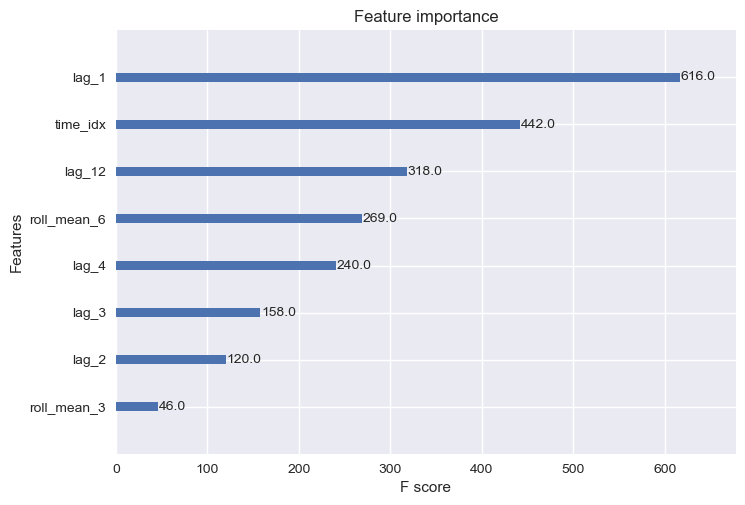

In [ ]:
# --- Baseline 2: XGBoost ---

def create_features(df, lags=[1, 2, 3, 4, 12], wins=[3, 6]):
    df_feat = df.copy()
    for lag in lags:
        df_feat[f'lag_{lag}'] = df_feat.groupby('series_id')['price'].shift(lag)
        
    for win in wins:
        df_feat[f'roll_mean_{win}'] = df_feat.groupby('series_id')['price'].transform(lambda x: x.shift(1).rolling(win).mean())
        
    return df_feat

print("Preparing features for XGBoost...")
df_xgb = create_features(df_agg)
df_xgb = df_xgb.dropna()

# Split
X = df_xgb.drop(columns=['price', 'date', 'series_id'])
y = df_xgb['price']
# We need to respect time split
train_mask = df_xgb['time_idx'] <= train_cutoff
test_mask = df_xgb['time_idx'] > train_cutoff

X_train, y_train = X[train_mask], y[train_mask]
X_test, y_test = X[test_mask], y[test_mask]

# Train
print("Training XGBoost...")
reg = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
reg.fit(X_train, y_train)

# Predict
xgb_preds = reg.predict(X_test)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_preds))
print(f"XGBoost RMSE: {xgb_rmse:.4f}")

# Feature Importance
xgb.plot_importance(reg, max_num_features=10)
plt.show()

In [ ]:
# --- Baseline 3: Temporal Fusion Transformer (TFT) ---

if HAS_TFT:
    print("Setting up TFT with improvements...")
    
    # Handle potential library mismatch between pytorch_lightning and lightning
    try:
        import lightning.pytorch as pl
        from lightning.pytorch.callbacks import EarlyStopping
        print("✅ Using lightning.pytorch")
    except ImportError:
        import pytorch_lightning as pl
        from pytorch_lightning.callbacks import EarlyStopping
        print("✅ Using pytorch_lightning")

    # --- Feature Engineering for TFT ---
    # 1. Add Month (Seasonality)
    df_agg['month'] = df_agg['date'].dt.month.astype(str).astype('category')
    
    # 2. Add Rolling Mean (Trend context)
    # Shift by 1 to ensure we don't leak current value into feature
    df_agg['price_roll_6'] = df_agg.groupby('series_id')['price'].transform(lambda x: x.shift(1).rolling(6).mean())
    # Fill NaNs created by rolling/shifting
    df_agg['price_roll_6'] = df_agg['price_roll_6'].bfill().fillna(0)

    # Encode series_id
    le = LabelEncoder()
    df_agg['series_id_enc'] = le.fit_transform(df_agg['series_id'].astype(str))
    
    # Create TimeSeriesDataSet
    max_prediction_length = config.PREDICTION_HORIZON
    max_encoder_length = config.SEQUENCE_LENGTH * 2 # Increase context
    training_cutoff = df_agg["time_idx"].max() - max_prediction_length

    print("Creating TimeSeriesDataSet...")
    training = TimeSeriesDataSet(
        df_agg[lambda x: x.time_idx <= training_cutoff],
        time_idx="time_idx",
        target="price",
        group_ids=["series_id"],
        min_encoder_length=max_encoder_length // 2,
        max_encoder_length=max_encoder_length,
        min_prediction_length=1,
        max_prediction_length=max_prediction_length,
        static_categoricals=["series_id"],
        time_varying_known_categoricals=["month"], # Known in future
        time_varying_known_reals=["time_idx"],
        time_varying_unknown_reals=["price", "price_roll_6"], # Only known in past
        target_normalizer=GroupNormalizer(
            groups=["series_id"], transformation="softplus"
        ),
        add_relative_time_idx=True,
        add_target_scales=True,
        add_encoder_length=True,
        allow_missing_timesteps=True
    )

    # Create dataloaders
    validation = TimeSeriesDataSet.from_dataset(training, df_agg, predict=True, stop_randomization=True)
    batch_size = 64
    train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
    val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

    # Configure Network - Increased complexity
    tft = TemporalFusionTransformer.from_dataset(
        training,
        learning_rate=0.03,
        hidden_size=32, # Increased from 16
        attention_head_size=4, # Increased from 1
        dropout=0.1,
        hidden_continuous_size=16, # Increased from 8
        output_size=7,
        loss=QuantileLoss(),
        log_interval=10,
        reduce_on_plateau_patience=4,
    )
    print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

    # Train with Early Stopping and more epochs
    trainer = pl.Trainer(
        max_epochs=50, # Increased from 10
        accelerator='auto',
        gradient_clip_val=0.1,
        limit_train_batches=50, # Increased limit
        enable_checkpointing=True,
        callbacks=[EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")]
    )
    
    print("Training TFT (this will take longer)...")
    trainer.fit(
        tft,
        train_dataloaders=train_dataloader,
        val_dataloaders=val_dataloader,
    )
    
    # Evaluate
    best_model_path = trainer.checkpoint_callback.best_model_path
    print(f"Loading best model from {best_model_path}")
    best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path, weights_only=False)
    
    actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
    predictions = best_tft.predict(val_dataloader)
    
    # Calculate RMSE
    tft_rmse = torch.sqrt(torch.mean((actuals - predictions) ** 2)).item()
    print(f"TFT RMSE: {tft_rmse:.4f}")
    
else:
    print("Skipping TFT (library not available)")
    tft_rmse = None

Setting up TFT with improvements...
✅ Using lightning.pytorch
Creating TimeSeriesDataSet...


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


Number of parameters in network: 1182.7k
Training TFT (this will take longer)...


┏━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃    ┃ Name                               ┃ Type                            ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0  │ loss                               │ QuantileLoss                    │      0 │ train │     0 │
│ 1  │ logging_metrics                    │ ModuleList                      │      0 │ train │     0 │
│ 2  │ input_embeddings                   │ MultiEmbedding                  │  1.1 M │ train │     0 │
│ 3  │ prescalers                         │ ModuleDict                      │    224 │ train │     0 │
│ 4  │ static_variable_selection          │ VariableSelectionNetwork        │  6.0 K │ train │     0 │
│ 5  │ encoder_variable_selection         │ VariableSelectionNetwork        │  8.0 K │ train │     0 │
│ 6  │ decoder_variable_selection         │ VariableSelectionNetwork        │  4.0 K │ train │     0 │
│ 7  │ static_context_variable_selection  │ GatedResidualNetwork            │  4.3 K │ train │     0 │
│ 8  │ static_context_initial_hidden_lstm │ GatedResidualNetwork            │  4.3 K │ train │     0 │
│ 9  │ static_context_initial_cell_lstm   │ GatedResidualNetwork            │  4.3 K │ train │     0 │
│ 10 │ static_context_enrichment          │ GatedResidualNetwork            │  4.3 K │ train │     0 │
│ 11 │ lstm_encoder                       │ LSTM                            │  8.4 K │ train │     0 │
│ 12 │ lstm_decoder                       │ LSTM                            │  8.4 K │ train │     0 │
│ 13 │ post_lstm_gate_encoder             │ GatedLinearUnit                 │  2.1 K │ train │     0 │
│ 14 │ post_lstm_add_norm_encoder         │ AddNorm                         │     64 │ train │     0 │
│ 15 │ static_enrichment                  │ GatedResidualNetwork            │  5.3 K │ train │     0 │
│ 16 │ multihead_attn                     │ InterpretableMultiHeadAttention │  2.6 K │ train │     0 │
│ 17 │ post_attn_gate_norm                │ GateAddNorm                     │  2.2 K │ train │     0 │
│ 18 │ pos_wise_ff                        │ GatedResidualNetwork            │  4.3 K │ train │     0 │
│ 19 │ pre_output_gate_norm               │ GateAddNorm                     │  2.2 K │ train │     0 │
│ 20 │ output_layer                       │ Linear                          │    231 │ train │     0 │
└────┴────────────────────────────────────┴─────────────────────────────────┴────────┴───────┴───────┘

Trainable params: 1.2 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.2 M                                                                                                
Total estimated model params size (MB): 4                                                                          
Modules in train mode: 307                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

Loading best model from /Users/goffy/Desktop/CASA0004/ex2_housing/lightning_logs/version_5/checkpoints/epoch=48-step=2450.ckpt


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


TFT RMSE: 71027.5781


In [ ]:
# --- Baseline 4: TabNet ---

if HAS_TABNET:
    print("Setting up TabNet...")
    
    # TabNet uses the same tabular features as XGBoost
    # But it needs numpy arrays and prefers float32
    
    X_train_np = X_train.values.astype(np.float32)
    y_train_np = y_train.values.reshape(-1, 1).astype(np.float32)
    X_test_np = X_test.values.astype(np.float32)
    y_test_np = y_test.values.reshape(-1, 1).astype(np.float32)
    
    print(f"TabNet Training Data Shape: {X_train_np.shape}")
    
    # Initialize TabNet
    # We force 'cpu' here to avoid potential MPS (Metal Performance Shaders) hangs on macOS
    # If you have a CUDA GPU, you can change this to 'cuda' or 'auto'
    clf = TabNetRegressor(
        verbose=1, 
        seed=42,
        optimizer_params=dict(lr=0.02),
        device_name='cpu'
    )
    
    print("Training TabNet...")
    clf.fit(
        X_train=X_train_np, y_train=y_train_np,
        eval_set=[(X_train_np, y_train_np), (X_test_np, y_test_np)],
        eval_name=['train', 'valid'],
        eval_metric=['rmse'],
        max_epochs=10, # Reduced epochs for baseline speed
        patience=5,
        batch_size=1024, 
        virtual_batch_size=128,
        num_workers=0,
        drop_last=False
    )
    
    tabnet_preds = clf.predict(X_test_np)
    tabnet_rmse = np.sqrt(mean_squared_error(y_test_np, tabnet_preds))
    print(f"TabNet RMSE: {tabnet_rmse:.4f}")
    
else:
    print("Skipping TabNet (library not available)")
    tabnet_rmse = None

Setting up TabNet...
TabNet Training Data Shape: (3188527, 8)
Training TabNet...
epoch 0  | loss: 39317138521.82157| train_rmse: 86831.7155| valid_rmse: 146754.90272|  0:03:11s
epoch 1  | loss: 3231329064.00144| train_rmse: 38517.49026| valid_rmse: 70012.85916|  0:06:27s
epoch 2  | loss: 1857688423.64958| train_rmse: 38574.63291| valid_rmse: 67528.2649|  0:09:42s
epoch 3  | loss: 1627044342.78693| train_rmse: 37134.90907| valid_rmse: 65265.64156|  0:12:57s
epoch 4  | loss: 1461664649.06908| train_rmse: 33986.16377| valid_rmse: 58229.57709|  0:16:14s
epoch 5  | loss: 1380047460.29551| train_rmse: 34157.56057| valid_rmse: 61134.28734|  0:19:28s
epoch 6  | loss: 1333965464.7901| train_rmse: 37460.88819| valid_rmse: 67913.25102|  0:22:40s
epoch 7  | loss: 1277899288.46989| train_rmse: 31489.27843| valid_rmse: 52417.31622|  0:25:51s
epoch 8  | loss: 1250996742.57973| train_rmse: 40714.17169| valid_rmse: 75374.33409|  0:29:02s
epoch 9  | loss: 1225160580.36519| train_rmse: 32490.95973| valid


=== Final Results ===
     Model          RMSE           MAE   MAPE (%)     rRMSE
0    ARIMA  54248.650122  39526.959941   8.982942  0.124702
1  XGBoost  88132.823085  25628.836410   6.285995  0.265131
2      TFT  71027.573688  36138.187500  10.060261  0.214110
3   TabNet  52417.316223  23090.675781   6.644926  0.157688


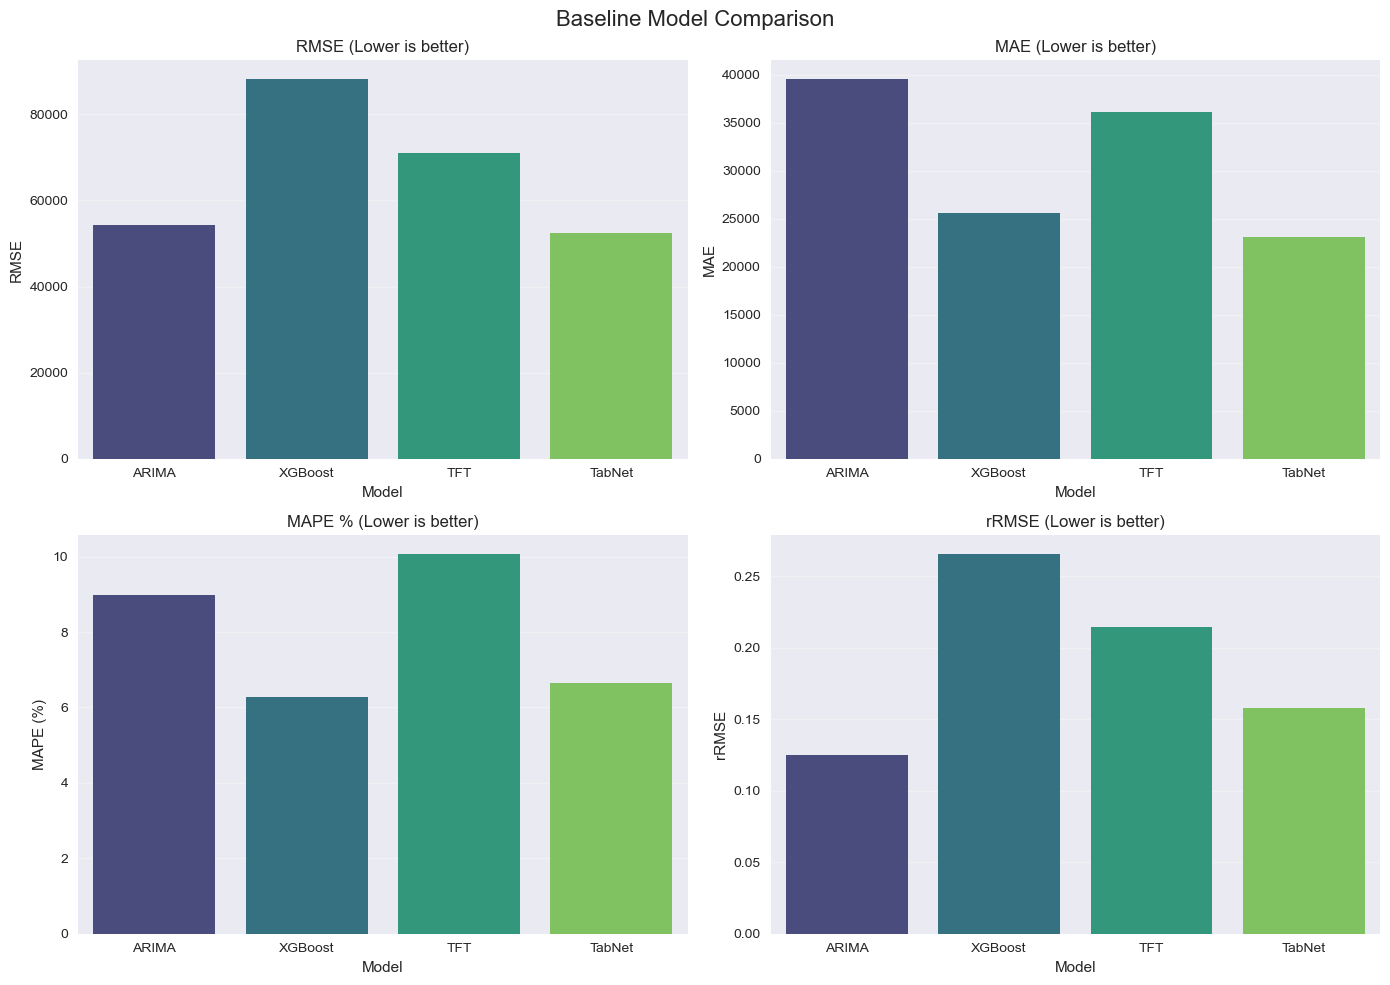

In [ ]:
# --- Model Comparison ---

def get_metrics(y_true, y_pred):
    """Calculate RMSE, MAE, MAPE, and rRMSE."""
    if y_true is None or y_pred is None or len(y_true) == 0:
        return np.nan, np.nan, np.nan, np.nan
    
    # Ensure numpy arrays and flatten
    if isinstance(y_true, torch.Tensor):
        y_true = y_true.cpu().numpy()
    if isinstance(y_pred, torch.Tensor):
        y_pred = y_pred.cpu().numpy()
        
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    
    # MAPE (Mean Absolute Percentage Error)
    # Handle division by zero
    mask = y_true != 0
    if np.sum(mask) > 0:
        mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    else:
        mape = np.nan
        
    # rRMSE (Relative RMSE)
    mean_true = np.mean(y_true)
    if mean_true != 0:
        rrmse = rmse / mean_true
    else:
        rrmse = np.nan
        
    return rmse, mae, mape, rrmse

# Collect metrics for all models
metrics_data = []

# 1. ARIMA
rmse, mae, mape, rrmse = get_metrics(arima_actuals, arima_preds)
metrics_data.append(['ARIMA', rmse, mae, mape, rrmse])

# 2. XGBoost
rmse, mae, mape, rrmse = get_metrics(y_test, xgb_preds)
metrics_data.append(['XGBoost', rmse, mae, mape, rrmse])

# 3. TFT
if HAS_TFT and 'actuals' in locals() and 'predictions' in locals():
    rmse, mae, mape, rrmse = get_metrics(actuals, predictions)
else:
    rmse, mae, mape, rrmse = np.nan, np.nan, np.nan, np.nan
metrics_data.append(['TFT', rmse, mae, mape, rrmse])

# 4. TabNet
if HAS_TABNET and 'y_test_np' in locals() and 'tabnet_preds' in locals():
    rmse, mae, mape, rrmse = get_metrics(y_test_np, tabnet_preds)
else:
    rmse, mae, mape, rrmse = np.nan, np.nan, np.nan, np.nan
metrics_data.append(['TabNet', rmse, mae, mape, rrmse])

# Create Results DataFrame
df_results = pd.DataFrame(metrics_data, columns=['Model', 'RMSE', 'MAE', 'MAPE (%)', 'rRMSE'])
print("\n=== Final Results ===")
print(df_results)

# Plot comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Baseline Model Comparison', fontsize=16)

# RMSE
sns.barplot(x='Model', y='RMSE', data=df_results, ax=axes[0, 0], palette='viridis')
axes[0, 0].set_title('RMSE (Lower is better)')
axes[0, 0].grid(axis='y', alpha=0.3)

# MAE
sns.barplot(x='Model', y='MAE', data=df_results, ax=axes[0, 1], palette='viridis')
axes[0, 1].set_title('MAE (Lower is better)')
axes[0, 1].grid(axis='y', alpha=0.3)

# MAPE
sns.barplot(x='Model', y='MAPE (%)', data=df_results, ax=axes[1, 0], palette='viridis')
axes[1, 0].set_title('MAPE % (Lower is better)')
axes[1, 0].grid(axis='y', alpha=0.3)

# rRMSE
sns.barplot(x='Model', y='rRMSE', data=df_results, ax=axes[1, 1], palette='viridis')
axes[1, 1].set_title('rRMSE (Lower is better)')
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()